In [2]:
import numpy as np
import pandas as pd
import rasterio as rio
import glob
import matplotlib.pyplot as plt
from pandarallel import pandarallel

In [3]:
strips = pd.read_pickle('../../data/strips.pkl')
grids = pd.read_pickle('../../data/grids.pkl')

print('Rasters:', len(strips))
print('Grids:', len(grids))

Rasters: 378
Grids: 901


In [4]:
def stack_rasters_frame(grid):
    '''
    Stacks the grid's rasters into one numpy array
    DIMENSIONS:
    0: time
    1: x
    2: y
    '''
    rasters = glob.glob('../../data/grids/' + str(grid.name) + '/*v3.0_dem.tif')  # grab all rasters
    rasters.sort(key=lambda x: x.split('_')[2])  # sort the rasters by date acquired

    frame = pd.DataFrame(columns=['dem', 'date', 'nodata'])
    for raster in rasters:
        date = pd.to_datetime(raster.split('_')[2]).strftime('%Y-%m-%d')  # Date Acquired

        dem = rio.open(raster).read(1) # Open Data 
        
        # Calculate Amount of No Data (100 means no data at all)        
        mask = rio.open(raster).read_masks(1).astype(float)  # Open Mask
        _, counts = np.unique(mask, return_counts=True)
        mask[mask==0] = np.nan
        nodata_val = counts[0] / (counts[0] + counts[1]) * 100
        
        # Apply Laser Altimetry Correction
        raster_name = raster[raster.rfind('/')+1:raster.rfind('_')]
        dem = dem + strips.loc[raster_name]['dz']
        dem = dem * mask / 255  # Mask the Data (no data becomes nan)
        
        if nodata_val < 90:
            frame.loc[len(frame)] = [dem, date, nodata_val]
        
    return frame

In [5]:
def average_raster(grid):
    
    out_dir = '../../data/average_rasters/'
    outfile = out_dir + str(grid.name) + '.tif'
    
    frame = stack_rasters_frame(grid)
    stack = np.stack(frame['dem'])
    avg = np.nanmean(stack, axis=0)
    
    rasters = glob.glob('../../data/grids/' + str(grid.name) + '/*v3.0_dem.tif')
    metadata = rio.open(rasters[0]).meta  # Get Metadata
    metadata.update({'dtype':'float64'})  # Update raster datatype to float64
    
    with rio.open(outfile, 'w', **metadata) as dst:
        dst.write(avg, 1)
    return

In [ ]:
pandarallel.initialize(progress_bar=True)
grids.parallel_apply(average_raster, axis='columns')

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


In [7]:
average_rasters = glob.glob('../../data/average_rasters/*.tif')
print(len(average_rasters))

901


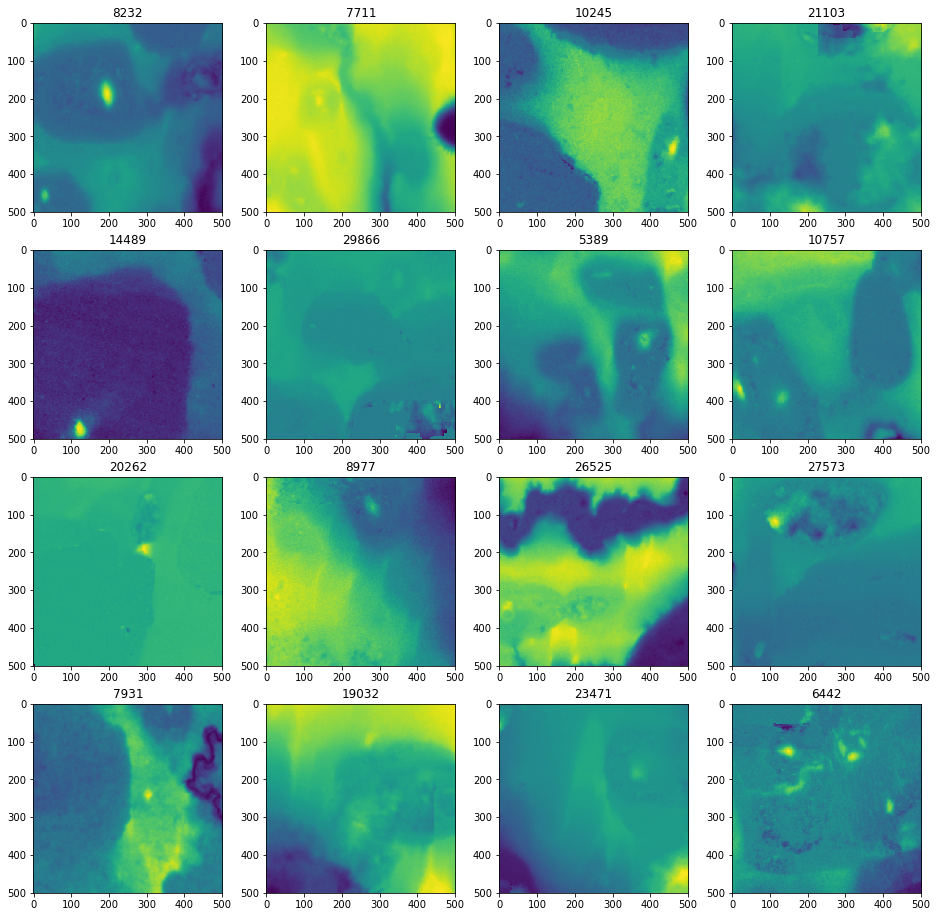

In [26]:
fig, axes = plt.subplots(4,4, figsize=(16,16))
i = 0
for ax in axes.reshape(-1):
    raster = np.random.choice(average_rasters)
    ax.imshow(rio.open(raster).read(1))
    ax.set_title(raster[raster.rfind('/')+1:raster.rfind('.')])
plt.show()